In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2

In [2]:
def balance_data(data, target_length):
    """Duplica casualmente le immagini per bilanciare le classi fino alla lunghezza target."""
    initial_data = data.copy()
    while len(data) < target_length:
        data.extend(random.sample(initial_data, min(len(initial_data), target_length - len(data))))
    return data[:target_length]  # Assicura che la lunghezza sia esatta


class BalancedCellDataset(Dataset):
    def __init__(self, csv_files, dataset_type, image_column="AllChannels", root_dir="", transform=None, balance=True, crop_radius=50):
        """
        Dataset personalizzato per caricare immagini dai CSV con bilanciamento opzionale e ritaglio centrato.

        Args:
        - csv_files (list): Lista dei file CSV [benigno, maligno].
        - dataset_type (str): Indica "train", "validation" o "test".
        - image_column (str): Colonna con i percorsi delle immagini.
        - root_dir (str): Percorso base delle immagini.
        - transform (callable, optional): Trasformazioni da applicare alle immagini.
        - balance (bool): Se True, bilancia solo il training set.
        - crop_radius (int): Raggio `r` per il ritaglio dell'immagine (default: 50 pixel).
        """
        self.transform = transform
        self.root_dir = root_dir
        self.crop_radius = crop_radius
        self.min_size = (100, 100)  # Dimensione minima richiesta

        benign_data = []
        malignant_data = []

        for csv_file, label, target_list in zip(csv_files, [0, 1], [benign_data, malignant_data]):
            df = pd.read_csv(csv_file)
            df["Set"] = df["Set"].str.strip().str.lower()
            dataset_type = dataset_type.lower()
            df = df[df["Set"] == dataset_type]

            for _, row in df.iterrows():
                img_path = os.path.join(
                    self.root_dir,
                    str(row["TypeOfCell"]),
                    str(row["Nome Acquisizione"]),
                    str(int(row["Numero cellula"])),  # Evita problemi con float
                    row[image_column]
                )
                target_list.append((img_path, label))

        if balance and dataset_type == "train":
            max_length = max(len(benign_data), len(malignant_data))
            self.data = balance_data(benign_data, max_length) + balance_data(malignant_data, max_length)
            random.shuffle(self.data)  # Evita pattern nei dati
        else:
            self.data = benign_data + malignant_data

    def pad_image_to_min_size(self, image, min_size=(100, 100)):
        """Aggiunge padding all'immagine se è più piccola delle dimensioni minime richieste."""
        h, w = image.shape[:2]
        pad_h = max(0, min_size[0] - h)
        pad_w = max(0, min_size[1] - w)

        if pad_h > 0 or pad_w > 0:
            # Calcola il padding su ogni lato per centrare l'immagine
            top = pad_h // 2
            bottom = pad_h - top
            left = pad_w // 2
            right = pad_w - left

            image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

        return image

    def crop_around_center(self, image, r):
        """Ritaglia un'area centrata sull'immagine in base al r specificato."""
        h, w = image.shape[:2]
        if h < 2 * r or w < 2 * r:
            raise ValueError(f"L'immagine è troppo piccola ({h}x{w}) per il ritaglio con r={r}")
        x1, x2 = (w // 2 - r, w // 2 + r)
        y1, y2 = (h // 2 - r, h // 2 + r)
        return image[y1:y2, x1:x2]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File non trovato: {img_path}")

        try:
            image = np.load(img_path)  # Carica come NumPy array
        except Exception as e:
            raise RuntimeError(f"Errore nel caricamento dell'immagine {img_path}: {e}")

        # **Passo 1: Padding se necessario**
        image = self.pad_image_to_min_size(image, self.min_size)

        # **Passo 2: Ritaglio**
        image = self.crop_around_center(image, self.crop_radius)

        # **Passo 3: Trasformazioni**
        if self.transform:
            image = self.transform(image)  # Passa il NumPy array alle trasformazioni

        return image, label


class Normalize01(torch.nn.Module):
    """Normalizza i valori di un tensore tra 0 e 1."""
    def __init__(self):
        super().__init__()

    def forward(self, img):
        min_val, max_val = img.min(), img.max()
        return (img - min_val) / (max_val - min_val) if max_val > min_val else torch.zeros_like(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'


In [15]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from captum.attr import GuidedBackprop, LayerIntegratedGradients, Saliency
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

# Definizione della funzione per trovare l'ultimo layer convoluzionale
def find_last_conv_layer(model):
    modules = list(model.modules())  # Converti il generatore in una lista
    for module in reversed(modules):  # Ora si può iterare all'indietro
        if isinstance(module, torch.nn.Conv2d):
            return module
    raise ValueError("Nessun layer convoluzionale trovato nel modello")

def apply_guided_backprop(model, image_tensor, target_class, save_path="./captum_guided_backprop_results", image_idx=0, title=None):
    model.eval()
    os.makedirs(save_path, exist_ok=True)

    guided_bp = GuidedBackprop(model)
    image_tensor.requires_grad = True
    attributions = guided_bp.attribute(image_tensor, target=target_class)

    attributions = attributions.abs().sum(dim=1).squeeze().detach().cpu().numpy()
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    if image_np.max() <= 1:
        image_np = (image_np * 255).astype(np.uint8)

    if image_np.shape[-1] == 2:
        zero_channel = np.zeros_like(image_np[:, :, 0])
        image_np = np.dstack([image_np, zero_channel])

    heatmap = cv2.applyColorMap(np.uint8(255 * attributions), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

    overlay = cv2.addWeighted(image_np, 0.5, heatmap, 0.5, 0)

    #save_filename = os.path.join(save_path, f"guided_backprop_{image_idx}.png")
    #plt.imsave(save_filename, overlay)
    # Salvataggio dell'immagine
    save_filename = os.path.join(save_path, f"{image_idx}_guided_backpropagation.png")

    # Plot and save with title
    plt.figure(figsize=(5, 5))
    plt.imshow(overlay, cmap='gray')  # or cmap='viridis' for color
    if title is not None:
        plt.title(title, fontsize=14)
    plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.savefig(save_filename, bbox_inches='tight', pad_inches=0.2)
    plt.close()

    #print(f"Salvata immagine Guided Backprop: {save_filename}")

    return overlay

def apply_integrated_gradients(model, image_tensor, target_class, save_path="./captum_ig_results", image_idx=0, return_attributions=False, abs_val=True, title=None):
    model.eval()
    os.makedirs(save_path, exist_ok=True)

    last_conv_layer = find_last_conv_layer(model)
    lig = LayerIntegratedGradients(model, last_conv_layer)

    attributions = lig.attribute(image_tensor, target=target_class, n_steps=50)

    if abs_val:
        attributions = attributions.abs().sum(dim=1).squeeze().detach().cpu().numpy()
    else:
        attributions = attributions.sum(dim=1).squeeze().detach().cpu().numpy()

    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

    if return_attributions:
        return attributions

    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    if image_np.shape[-1] == 2:
        image_np = np.dstack([image_np, np.zeros_like(image_np[:, :, 0])])

    heatmap = cv2.applyColorMap(np.uint8(255 * attributions), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

    if image_np.max() <= 1:
        image_np = (image_np * 255).astype(np.uint8)

    overlay = cv2.addWeighted(image_np, 0.5, heatmap, 0.5, 0)

    #save_filename = os.path.join(save_path, f"integrated_gradients_{image_idx}.png")
    #plt.imsave(save_filename, overlay)
    save_filename = os.path.join(save_path, f"{image_idx}_integrated_gradients.png")

    # Plot and save with title
    plt.figure(figsize=(5, 5))
    plt.imshow(overlay, cmap='gray')  # or cmap='viridis' for color
    if title is not None:
        plt.title(title, fontsize=14)
    plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.savefig(save_filename, bbox_inches='tight', pad_inches=0.2)
    plt.close()

    #print(f"Salvata immagine IG: {save_filename}")

    return overlay

def apply_saliency(model, image_tensor, target_class, save_path="./captum_saliency_results", image_idx=0, title=None):
    model.eval()
    os.makedirs(save_path, exist_ok=True)

    saliency = Saliency(model)
    image_tensor.requires_grad = True
    attributions = saliency.attribute(image_tensor, target=target_class)

    attributions = attributions.abs().sum(dim=1).squeeze().detach().cpu().numpy()
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Converti in uint8
    if image_np.max() <= 1:
        image_np = (image_np * 255).astype(np.uint8)

    # Se l'immagine ha 2 canali, convertirla a 3 canali aggiungendo un canale vuoto
    if image_np.shape[-1] == 2:
        zero_channel = np.zeros_like(image_np[:, :, 0])  # Canale vuoto
        image_np = np.dstack([image_np, zero_channel])  # Concatenazione

    # Creazione della heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * attributions), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Assicuriamoci che heatmap e image_np abbiano la stessa dimensione
    heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

    # Overlay finale
    overlay = cv2.addWeighted(image_np, 0.5, heatmap, 0.5, 0)

    # Salvataggio immagine
    #save_filename = os.path.join(save_path, f"saliency_{image_idx}.png")
    #plt.imsave(save_filename, overlay)
    save_filename = os.path.join(save_path, f"{image_idx}_saliency.png")

    # Plot and save with title
    plt.figure(figsize=(5, 5))
    plt.imshow(overlay, cmap='gray')  # or cmap='viridis' for color
    if title is not None:
        plt.title(title, fontsize=14)
    plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.savefig(save_filename, bbox_inches='tight', pad_inches=0.2)
    plt.close()

    #print(f"Salvata immagine Saliency: {save_filename}")

    return overlay

# Definizione della funzione per applicare Grad-CAM su immagini a 2 canali
def apply_gradcam(model, image_tensor, target_layer, class_idx=None, save_path="./gradcam_results", image_idx=0, title=None):
    model.eval()

    # Creare la cartella per salvare le immagini se non esiste
    os.makedirs(save_path, exist_ok=True)

    # Definire Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Definire il target della classe
    targets = [ClassifierOutputTarget(class_idx)] if class_idx is not None else None

    # Eseguire la heatmap
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)

    # Normalizzazione della heatmap
    grayscale_cam = grayscale_cam[0]  # Rimuove la dimensione batch

    # Convertire l'immagine tensor in formato numpy
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalizza a [0,1]

    # Convertire immagine a 3 canali per la visualizzazione (da 2 canali a 3 canali)
    if image_np.shape[-1] == 2:
        image_np = np.dstack([image_np, np.zeros_like(image_np[:, :, 0])])  # Aggiunge un terzo canale vuoto

    # Applicare la heatmap all'immagine
    visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    # Salvataggio dell'immagine
    save_filename = os.path.join(save_path, f"{image_idx}_gradcam.png")

    # Plot and save with title
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization, cmap='gray')  # or cmap='viridis' for color
    if title is not None:
        plt.title(title, fontsize=14)
    plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.savefig(save_filename, bbox_inches='tight', pad_inches=0.2)
    plt.close()

    #plt.imsave(save_filename, visualization)
    #print(f"Salvata immagine Grad-CAM: {save_filename}")

    return visualization

# Funzione di valutazione con integrazione di Grad-CAM
def evaluate_model(model, test_loader, device, save_path, test_set_name):
    model.load_state_dict(torch.load(save_path, map_location=device))
    save_path = save_path[:-4]
    test_save_path = os.path.join(save_path, test_set_name)
    os.makedirs(test_save_path, exist_ok=True)
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    target_layer = find_last_conv_layer(model)  # Trova automaticamente l'ultimo layer convoluzionale
    image_idx = 0  # Contatore immagini Grad-CAM

    for images, labels in tqdm(test_loader):
        images, labels = images.to(device, dtype=torch.float32), labels.to(device)

        with torch.no_grad():  # Disattiva grad solo per inferenza standard
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(probs, dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

        # Applicazione di Grad-CAM su ogni immagine del batch SENZA torch.no_grad()
        for i in range(images.shape[0]):
            is_correct = predicted[i].item() == labels[i].item()
            
            #print(f'Predicted: {predicted[i]}')
            #print(f'Target: {labels[i]}')
            # Plot and save with title
            text = f'PR{predicted[i].item()}_GT{labels[i].item()}'
            name = f"{image_idx}_{text}"
            if not is_correct:
                print(name)
            
            # New slice of zeros with shape (1, 224, 224)
            #zero_slice = torch.zeros(images[i].shape[1:]).unsqueeze(0)

            # Concatenate along the first dimension
            #fixed_image = torch.cat((images[i], zero_slice), dim=0)
            m_filename = os.path.join(test_save_path, f"{image_idx}_membrane.png")
            m_image = images[i][0]
            #fixed_m_image = m_image.permute(1, 2, 0)

            if not os.path.exists(m_filename):
                plt.figure(figsize=(5, 5))
                plt.imshow(m_image, cmap='gray')  # or cmap='viridis' for color
                plt.title(image_idx, fontsize=14)
                plt.axis('off')  # Hide axes
                plt.tight_layout()
                plt.savefig(m_filename, bbox_inches='tight', pad_inches=0.2)
                plt.close()

            n_filename = os.path.join(test_save_path, f"{image_idx}_nucleus.png")
            n_image = images[i][1]
            #fixed_n_image = n_image.permute(1, 2, 0)

            if not os.path.exists(n_filename):
                plt.figure(figsize=(5, 5))
                plt.imshow(n_image, cmap='gray')  # or cmap='viridis' for color
                plt.title(image_idx, fontsize=14)
                plt.axis('off')  # Hide axes
                plt.tight_layout()
                plt.savefig(n_filename, bbox_inches='tight', pad_inches=0.2)
                plt.close()

            if not os.path.exists(os.path.join(test_save_path, f"{name}_gradcam.png")) or not is_correct:
                apply_gradcam(model, images[i].unsqueeze(0), target_layer, class_idx=labels[i].item(), 
                          save_path=test_save_path, image_idx=name, title=text)

            if not os.path.exists(os.path.join(test_save_path, f"{name}_integrated_gradients.png")) or not is_correct:
                apply_integrated_gradients(model, images[i].unsqueeze(0), target_class=labels[i].item(),
                                       save_path=test_save_path, image_idx=name, title=text)
            
            if not os.path.exists(os.path.join(test_save_path, f"{name}_saliency.png")) or not is_correct:
                apply_saliency(model, images[i].unsqueeze(0), target_class=labels[i].item(),
                           save_path=test_save_path, image_idx=name, title=text)

            if not os.path.exists(os.path.join(test_save_path, f"{name}_guided_backpropagation.png")) or not is_correct:
                apply_guided_backprop(model, images[i].unsqueeze(0), target_class=labels[i].item(),
                                  save_path=test_save_path, image_idx=name, title=text)
            image_idx += 1

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="binary", zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    print("\nMetriche di valutazione:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, precision, recall, f1, auc

In [16]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch
import timm
'''
MICHI: FAI SOLO IL CHECK DEI VALORI DOPO LA ToTensor SE SONO VERAMENTE TRA 0 E 1 .. Se non lo sono, non fa niente! Tanto abbiamo la Normalize01
'''
import torchvision.transforms as transforms

def check_tensor_range(img):
    """ Controlla se i valori del tensore sono nel range [0,1] dopo ToTensor. """
    if img.min() < 0 or img.max() > 1:
        print("Warning: Tensor values are out of range [0,1] after ToTensor")

def pad_to_100x100(img):
    """ Aggiunge padding nero per rendere l'immagine 100x100 se necessario. """
    _, h, w = img.shape  # Ottieni altezza e larghezza
    if h == 100 and w == 100:
        return img  # Se è già 100x100, non serve padding

    # Calcola il padding necessario
    pad_h = max(0, (100 - h) // 2)
    pad_w = max(0, (100 - w) // 2)

    # Applica il padding uniformemente sopra/sotto e a sinistra/destra
    return transforms.functional.pad(img, (pad_w, pad_h, pad_w, pad_h), fill=0)

def lambda_check_range(x):
    return (check_tensor_range(x), x)[1]
# Trasformazioni per il training (include data augmentation)
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda_check_range),  # Controllo range senza modificarlo
    transforms.Resize((224, 224)),  # Porta l'immagine alla dimensione richiesta dal modello
    transforms.RandomRotation(degrees=90),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    Normalize01()
])

# Trasformazioni per validazione e test
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda_check_range),
    transforms.Resize((224, 224)),  # Porta tutto a 224x224 per il modello
    Normalize01()
])

# Percorsi ai file CSV e directory di base
csv_files_C = [
    "DICMAPI_Progetto/Dataset_Finale/csv/labeled/mcf7ControlCells_wo_mask_labeled.csv",
    "DICMAPI_Progetto/Dataset_Finale/csv/labeled/mcf10aControlCells_wo_mask_labeled.csv"
]
root_dir = "DICMAPI_Progetto/Dataset_Finale"

csv_files_E = [
    "DICMAPI_Progetto/Dataset_Finale/csv/labeled/mcf7CdExposed_wo_mask_labeled.csv",
    "DICMAPI_Progetto/Dataset_Finale/csv/labeled/mcf10aCdExposed_wo_mask_labeled.csv"
]

# Parametri
image_column = "CellNucleus"

# Creazione dei Dataset con crop_radius specifico per ogni set
train_dataset = BalancedCellDataset(
    csv_files_C,
    dataset_type="train",
    image_column=image_column,
    root_dir=root_dir,
    transform=train_transform,
    balance=True,
    crop_radius=50  # Imposta r per ritagli 2rx2r
)

val_dataset = BalancedCellDataset(
    csv_files_C,
    dataset_type="validation",
    image_column=image_column,
    root_dir=root_dir,
    transform=val_test_transform,
    crop_radius=50  # Mantiene r = 50 pixel → ritagli 100x100
)

test_dataset_C = BalancedCellDataset(
    csv_files_C,
    dataset_type="test",
    image_column=image_column,
    root_dir=root_dir,
    transform=val_test_transform,
    crop_radius=50  # Mantiene r = 50 pixel → ritagli 100x100
)

test_dataset_E = BalancedCellDataset(
    csv_files=csv_files_E,
    dataset_type="test",
    image_column=image_column,
    root_dir=root_dir,
    transform=val_test_transform,
    crop_radius=50  # Mantiene r = 50 pixel → ritagli 100x100
)

batch_size = 32


# Creazione dei DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader_C = DataLoader(test_dataset_C, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader_E = DataLoader(test_dataset_E, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Configura il numero di canali di input
num_input_channels = 2  # Cambia a 2 se hai immagini bic-anale
num_classes = 2  # Numero di classi nel dataset

print("Caricamento del modello EfficientNetB0 con timm...")
model = timm.create_model('efficientnet_b0', pretrained=True, in_chans=num_input_channels, num_classes=num_classes)

# Sposta il modello su GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Modello EfficientNetB0 caricato e adattato per {num_input_channels} canali di input.")


Caricamento del modello EfficientNetB0 con timm...
Modello EfficientNetB0 caricato e adattato per 2 canali di input.


Eseguo l'inferenza con il modello E (Exposed) sul test set C (Control)...


  0%|          | 0/27 [00:00<?, ?it/s]

/Users/salvatorecapuozzo/anaconda3/envs/dl_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


38_PR1_GT0


/Users/salvatorecapuozzo/anaconda3/envs/dl_env/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


47_PR1_GT0
49_PR1_GT0
56_PR1_GT0
78_PR1_GT0
93_PR1_GT0
149_PR1_GT0
153_PR1_GT0
155_PR1_GT0
213_PR1_GT0
252_PR1_GT0
287_PR1_GT0
318_PR1_GT0
339_PR1_GT0
384_PR1_GT0
452_PR1_GT0
474_PR1_GT0
476_PR1_GT0
588_PR0_GT1
599_PR0_GT1
611_PR0_GT1
615_PR0_GT1
618_PR0_GT1
637_PR0_GT1
644_PR0_GT1
645_PR0_GT1
651_PR0_GT1
671_PR0_GT1
683_PR0_GT1
684_PR0_GT1
697_PR0_GT1
719_PR0_GT1
772_PR0_GT1
797_PR0_GT1
803_PR0_GT1
809_PR0_GT1
814_PR0_GT1
819_PR0_GT1
822_PR0_GT1
832_PR0_GT1
837_PR0_GT1

Metriche di valutazione:
Accuracy: 0.9519
Precision: 0.9350
Recall: 0.9184
F1-score: 0.9267
AUC: 0.9814


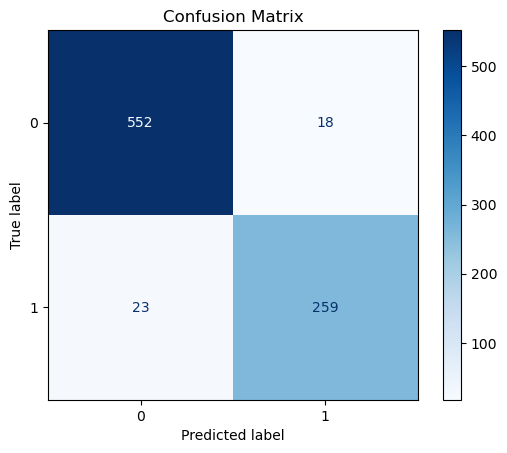


Eseguo l'inferenza con il modello E (Exposed) sul test set E (Exposed)...


  0%|          | 0/35 [00:00<?, ?it/s]

/Users/salvatorecapuozzo/anaconda3/envs/dl_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2_PR1_GT0


/Users/salvatorecapuozzo/anaconda3/envs/dl_env/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


55_PR1_GT0
60_PR1_GT0
116_PR1_GT0
120_PR1_GT0
242_PR1_GT0
358_PR1_GT0
383_PR1_GT0
439_PR1_GT0
457_PR1_GT0
513_PR1_GT0
517_PR1_GT0
549_PR1_GT0
647_PR1_GT0
785_PR0_GT1
797_PR0_GT1
799_PR0_GT1
801_PR0_GT1
807_PR0_GT1
817_PR0_GT1
831_PR0_GT1
834_PR0_GT1
848_PR0_GT1
860_PR0_GT1
863_PR0_GT1
879_PR0_GT1
881_PR0_GT1
908_PR0_GT1
910_PR0_GT1
912_PR0_GT1
935_PR0_GT1
965_PR0_GT1
972_PR0_GT1
990_PR0_GT1
992_PR0_GT1
1023_PR0_GT1
1048_PR0_GT1
1058_PR0_GT1
1059_PR0_GT1
1063_PR0_GT1
1067_PR0_GT1
1074_PR0_GT1
1075_PR0_GT1
1084_PR0_GT1

Metriche di valutazione:
Accuracy: 0.9599
Precision: 0.9544
Recall: 0.9071
F1-score: 0.9302
AUC: 0.9924


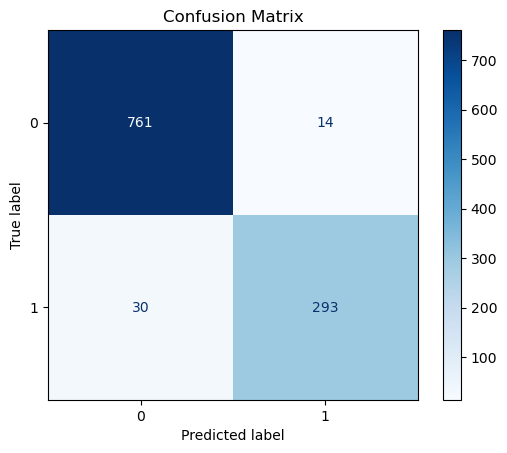


Eseguo l'inferenza con il modello C (Control) sul test set C (Control)...


  0%|          | 0/27 [00:00<?, ?it/s]

/Users/salvatorecapuozzo/anaconda3/envs/dl_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


72_PR1_GT0


/Users/salvatorecapuozzo/anaconda3/envs/dl_env/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


92_PR1_GT0
116_PR1_GT0
199_PR1_GT0
222_PR1_GT0
258_PR1_GT0
279_PR1_GT0
287_PR1_GT0
289_PR1_GT0
457_PR1_GT0
535_PR1_GT0
615_PR0_GT1
644_PR0_GT1
645_PR0_GT1
682_PR0_GT1
684_PR0_GT1
697_PR0_GT1
710_PR0_GT1
772_PR0_GT1

Metriche di valutazione:
Accuracy: 0.9777
Precision: 0.9614
Recall: 0.9716
F1-score: 0.9665
AUC: 0.9979


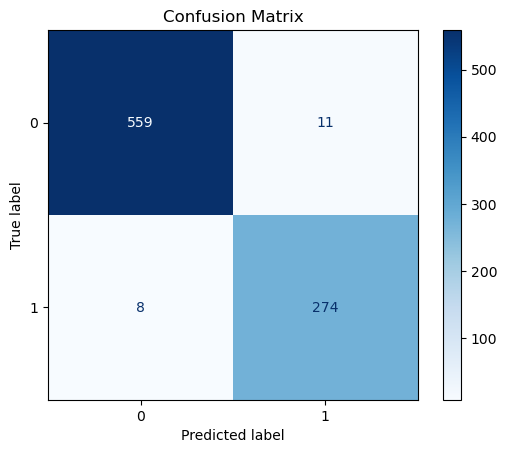


Eseguo l'inferenza con il modello C (Control) sul test set E (Exposed)...


  0%|          | 0/35 [00:00<?, ?it/s]

/Users/salvatorecapuozzo/anaconda3/envs/dl_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2_PR1_GT0


/Users/salvatorecapuozzo/anaconda3/envs/dl_env/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


25_PR1_GT0
34_PR1_GT0
55_PR1_GT0
60_PR1_GT0
86_PR1_GT0
96_PR1_GT0
135_PR1_GT0
137_PR1_GT0
166_PR1_GT0
207_PR1_GT0
240_PR1_GT0
243_PR1_GT0
330_PR1_GT0
346_PR1_GT0
347_PR1_GT0
350_PR1_GT0
351_PR1_GT0
358_PR1_GT0
361_PR1_GT0
363_PR1_GT0
364_PR1_GT0
370_PR1_GT0
372_PR1_GT0
377_PR1_GT0
380_PR1_GT0
381_PR1_GT0
383_PR1_GT0
385_PR1_GT0
389_PR1_GT0
397_PR1_GT0
398_PR1_GT0
403_PR1_GT0
417_PR1_GT0
513_PR1_GT0
515_PR1_GT0
561_PR1_GT0
619_PR1_GT0
625_PR1_GT0
627_PR1_GT0
630_PR1_GT0
633_PR1_GT0
635_PR1_GT0
746_PR1_GT0
769_PR1_GT0
799_PR0_GT1
807_PR0_GT1
818_PR0_GT1
827_PR0_GT1
830_PR0_GT1
831_PR0_GT1
832_PR0_GT1
833_PR0_GT1
834_PR0_GT1
835_PR0_GT1
836_PR0_GT1
860_PR0_GT1
861_PR0_GT1
865_PR0_GT1
867_PR0_GT1
869_PR0_GT1
870_PR0_GT1
881_PR0_GT1
899_PR0_GT1
908_PR0_GT1
910_PR0_GT1
936_PR0_GT1
952_PR0_GT1
958_PR0_GT1
992_PR0_GT1

Metriche di valutazione:
Accuracy: 0.9362
Precision: 0.8688
Recall: 0.9226
F1-score: 0.8949
AUC: 0.9800


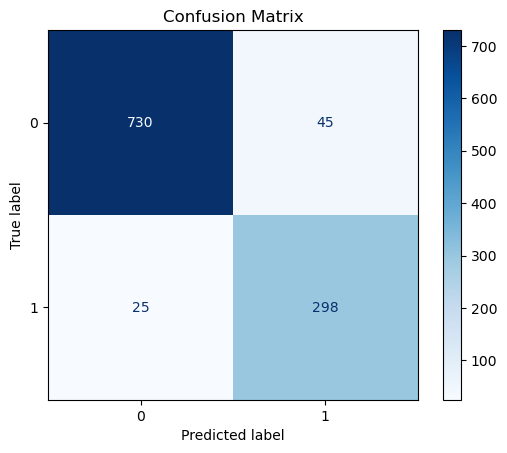

In [17]:
# Eseguire l'inferenza sui test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path_E = "DICMAPI_Progetto/pesi/best_weights_EfficientNet_Modello_E.pth"

print("Eseguo l'inferenza con il modello E (Exposed) sul test set C (Control)...")
testC_accuracy, testC_precision, testC_recall, testC_f1, testC_auc = evaluate_model(model, test_loader_C, device, save_path_E, "test_set_C")

print("\nEseguo l'inferenza con il modello E (Exposed) sul test set E (Exposed)...")
testE_accuracy, testE_precision, testE_recall, testE_f1, testE_auc = evaluate_model(model, test_loader_E, device, save_path_E, "test_set_E")

save_path_C = "DICMAPI_Progetto/pesi/best_weights_EfficientNet_Modello_C.pth"

print("\nEseguo l'inferenza con il modello C (Control) sul test set C (Control)...")
testC_accuracy, testC_precision, testC_recall, testC_f1, testC_auc = evaluate_model(model, test_loader_C, device, save_path_C, "test_set_C")

print("\nEseguo l'inferenza con il modello C (Control) sul test set E (Exposed)...")
testE_accuracy, testE_precision, testE_recall, testE_f1, testE_auc = evaluate_model(model, test_loader_E, device, save_path_C, "test_set_E")


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_png_images(directory):
    # Lista tutti i file nella directory
    files = [f for f in os.listdir(directory) if f.lower().endswith('.png')]

    if not files:
        print("Nessuna immagine PNG trovata nella cartella.")
        return

    for file in files:
        image_path = os.path.join(directory, file)
        img = Image.open(image_path)

        # Mostra l'immagine
        plt.figure()
        plt.imshow(img)
        plt.axis('off')  # Nasconde gli assi
        plt.title(file)
        plt.show()



In [ ]:
# Esempio di utilizzo
directory_path_C = "/content/drive/MyDrive/DeepLearningResults/test_set_C"
directory_path_E = "/content/drive/MyDrive/DeepLearningResults/test_set_E"
show_png_images(directory_path_C)
show_png_images(directory_path_E)
